Due to the size of dataset, it is not included in this repository, however, you can download it through https://www.kaggle.com/jeromeblanchet/drivendatas-boxplots-for-education-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Introducing the challenge
- Budgets for schools are huge, complex, and not standardize.
- Hundreds of hours each year are spent manually labelling
- Goal: Build a machine learning algorithm that can automate the process
- Supervised Learning problem

In [28]:
fn = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_2533/datasets/TrainingSetSample.csv'
from urllib.request import urlretrieve
urlretrieve(fn, 'TrainingData.csv')

('TrainingData.csv', <http.client.HTTPMessage at 0x1da00047088>)

In [29]:
df = pd.read_csv('TrainingData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1560 non-null   int64  
 1   Function                1560 non-null   object 
 2   Use                     1560 non-null   object 
 3   Sharing                 1560 non-null   object 
 4   Reporting               1560 non-null   object 
 5   Student_Type            1560 non-null   object 
 6   Position_Type           1560 non-null   object 
 7   Object_Type             1560 non-null   object 
 8   Pre_K                   1560 non-null   object 
 9   Operating_Status        1560 non-null   object 
 10  Object_Description      1461 non-null   object 
 11  Text_2                  382 non-null    object 
 12  SubFund_Description     1183 non-null   object 
 13  Job_Title_Description   1131 non-null   object 
 14  Text_3                  296 non-null    

We can see that some of the column names correspond to features - descriptions of the budget items - such as the Job_Title_Description column. The values in this column tell us if a budget item is for a teacher, custodian, or other employee.

and some columns correspond to the budget item labels you will be trying to predict with your model. For example, the Object_Type column describes whether the budget item is related classroom supplies, salary, travel expenses, etc.

Using df.info(), in the IPython Shell, we see figured out which columns of the data are numeric, specifically type float64. There are two numeric columns, called FTE and Total.

FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.
Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

In [4]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


Text(0, 0.5, 'num employee')

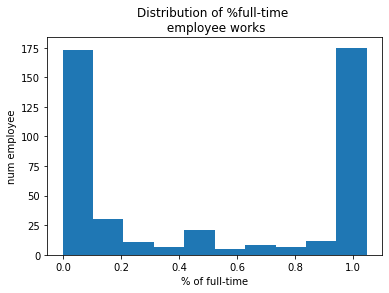

In [30]:
plt.hist(df['FTE'].dropna(), bins=10)

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employee')

### Looking at the datatypes
- ML algorithms work on numbers, not strings
- Need a numeric representation of these strings
- Strings can be slow compared to numbers
- In pandas, category dtype encodes categorical data numerically,
Can speed up code

### Exploring datatypes in pandas
It's always good to know what datatypes you're working with, especially when the inefficient pandas type object may be involved. Towards that end, let's explore what we have.

In [31]:
df.dtypes.value_counts()

object     23
float64     2
int64       1
dtype: int64

### Encode the labels as categorical variables
Remember, your ultimate goal is to predict the probability that a certain label is attached to a budget line item. You just saw that many columns in your data are the inefficient object type. Does this include the labels you're trying to predict? Let's find out!

There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take.

In [32]:
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type',
          'Object_Type', 'Pre_K', 'Operating_Status']

In [33]:
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a category type
df[LABELS] = categorize_label(df[LABELS])

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


### Counting unique labels

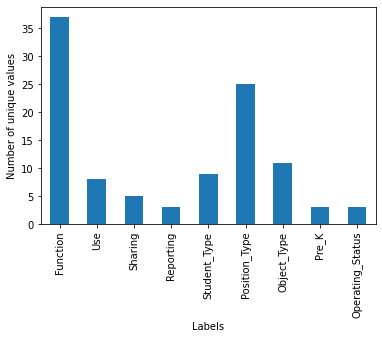

In [41]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique, axis=0)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

### How do we measure success?
- Accuracy can be misleading when classes are imbalanced
    - Legitmate email: 99%, Spam: 1%
    - Model that never predicts spam will be 99% accurate!
- Metric used in this problem: log loss
    - Loss function
    - Measure of error
    - Want to minimize the error (unlike accuracy)
- Log loss binary classification
     = $$-\frac{1}{N}\sum_{i=1}^N (y_i \log (p_i))+ (1-y_i)\log (1-p_i)) $$
    - Actual value: $y: {1=\text{yes}, ~~0=\text{no}}~~~y:1=yes,0=no$
    - Prediction (probability that the value is 1): pp

### Computing log loss with NumPy
To see how the log loss metric handles the trade-off between accuracy and confidence, we will use some sample data generated with NumPy and compute the log loss using the provided function compute_log_loss()

In [35]:
def compute_log_loss(predicted, actual, eps=1e-14):
    """Compute the logarithmic loss between predicted and
       actual when these are 1D arrays

       :param predicted: The predicted probabilties as floats between 0-1
       :param actual: The actual binary labels. Either 0 or 1
       :param eps (optional): log(0) is inf, so we need to offset our
                               predicted values slightly by eps from 0 or 1.
    """
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
    return loss

In [36]:
def compute_log_loss(predicted, actual, eps=1e-14):
    """Compute the logarithmic loss between predicted and
       actual when these are 1D arrays

       :param predicted: The predicted probabilties as floats between 0-1
       :param actual: The actual binary labels. Either 0 or 1
       :param eps (optional): log(0) is inf, so we need to offset our
                               predicted values slightly by eps from 0 or 1.
    """
    predicted = np.clip(predicted, eps, 1-eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
    return loss

In [37]:
correct_confident = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.05, 0.05, 0.05, 0.05, 0.05])
correct_not_confident = np.array([0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35])
wrong_not_confident = np.array([0.35, 0.35, 0.35, 0.35, 0.35, 0.65, 0.65, 0.65, 0.65, 0.65])
wrong_confident = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.95, 0.95, 0.95, 0.95, 0.95])
actual_labels = np.array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [38]:
correct_confident_loss = compute_log_loss(correct_confident, actual_labels)
print("Log loss, correct and confident: {}".format(correct_confident_loss)) 

# Compute log loss for 2nd case
correct_not_confident_loss = compute_log_loss(correct_not_confident, actual_labels)
print("Log loss, correct and not confident: {}".format(correct_not_confident_loss)) 

# Compute and print log loss for 3rd case
wrong_not_confident_loss = compute_log_loss(wrong_not_confident, actual_labels)
print("Log loss, wrong and not confident: {}".format(wrong_not_confident_loss)) 

# Compute and print log loss for 4th case
wrong_confident_loss = compute_log_loss(wrong_confident, actual_labels)
print("Log loss, wrong and confident: {}".format(wrong_confident_loss)) 

# Compute and print log loss for actual labels
actual_labels_loss = compute_log_loss(actual_labels, actual_labels)
print("Log loss, actual labels: {}".format(actual_labels_loss)) 

Log loss, correct and confident: 0.05129329438755058
Log loss, correct and not confident: 0.4307829160924542
Log loss, wrong and not confident: 1.049822124498678
Log loss, wrong and confident: 2.9957322735539904
Log loss, actual labels: 9.99200722162646e-15


# Time to build model
## Setting up a train-test split in scikit-learn

The first step is to split the data into a training set and a test set. Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. We provide a function that will make sure at least min_count examples of each label appear in each split: multilabel_train_test_split.

In [39]:
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

We'll start with a simple model that uses just the numeric columns of your DataFrame when calling multilabel_train_test_split.

In [17]:
NUMERIC_COLUMNS = ['FTE', 'Total']

In [18]:
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000).copy()

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only, label_dummies,
                                                               size=0.2, seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")
print(X_test.info())
print("\ny_train info:")
print(y_train.info())
print("\ny_test info:")
print(y_test.info())

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   FTE     320222 non-null  float64
 1   Total   320222 non-null  float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 72072
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     80055 non-null  float64
 1   Total   80055 non-null  float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 72072
Columns: 104 entries, Funct

### Training a model
We will import the logistic regression and one versus rest classifiers in order to fit a multi-class logistic regression model to the NUMERIC_COLUMNS of your feature data.

Then we'll test and print the accuracy with the .score() method to see the results of training.

Before we train!we're ultimately going to be using logloss to score our model, so don't worry too much about the accuracy here. Keep in mind that we're throwing away all of the text data in the dataset - that's by far most of the data!  We're just interested in getting things up and running at the moment.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.0


Ok! The good news is that our workflow didn't cause any errors. The bad news is that the model scored the lowest possible accuracy: 0.0! The reason is, we just threw away ALL of the text data in the budget. Later, we won't. Before we add the text data, let's see how the model does when scored by log loss.

### Making predictions
We need to remind ourselves that the original goal is to predict the probability of each label. Now, we'll do just that by using the .predict_proba() method on our trained model.

In [42]:
fn = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetSample.csv'
from urllib.request import urlretrieve
urlretrieve(fn, 'HoldoutData.csv')

('HoldoutData.csv', <http.client.HTTPMessage at 0x1da002c6ec8>)

In [43]:
holdout = pd.read_csv('HoldoutData.csv')

In [45]:
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

In [64]:
# Load path to pred
PATH_TO_PREDICTIONS = "predictions.csv"
# Load path to holdout
PATH_TO_HOLDOUT_DATA = "https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetSample.csv"
PATH_TO_HOLDOUT_LABELS = "https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetLabelsSample.csv"

# SCORING UTILITIES

BOX_PLOTS_COLUMN_INDICES = [range(37),
 range(37,48),
 range(48,51),
 range(51,76),
 range(76,79),
 range(79,82),
 range(82,87),
 range(87,96),
 range(96,104)]

def _multi_multi_log_loss(predicted,
    actual,
    class_column_indices=BOX_PLOTS_COLUMN_INDICES,
    eps=1e-15):

    class_scores = np.ones(len(class_column_indices), dtype=np.float64)

    # calculate log loss for each set of columns that belong to a class:
    for k, this_class_indices in enumerate(class_column_indices):
        # get just the columns for this class
        preds_k = predicted[:, this_class_indices].astype(np.float64)

        # normalize so probabilities sum to one (unless sum is zero, then we clip)
        preds_k /= np.clip(preds_k.sum(axis=1).reshape(-1, 1), eps, np.inf)

        actual_k = actual[:, this_class_indices]

        # shrink predictions so
        y_hats = np.clip(preds_k, eps, 1 - eps)
        sum_logs = np.sum(actual_k * np.log(y_hats))
        class_scores[k] = (-1.0 / actual.shape[0]) * sum_logs

        return np.average(class_scores)


def score_submission(pred_path=PATH_TO_PREDICTIONS, holdout_path=PATH_TO_HOLDOUT_LABELS):
    # this happens on the backend to get the score
    holdout_labels = pd.get_dummies(
    pd.read_csv(holdout_path, index_col=0)
    .apply(lambda x: x.astype('category'), axis=0)
    )

    preds = pd.read_csv(pred_path, index_col=0)

    # make sure that format is correct
    assert (preds.columns == holdout_labels.columns).all()
    assert (preds.index == holdout_labels.index).all()

    return _multi_multi_log_loss(preds.values, holdout_labels.values)

# Load holdout data
holdout = pd.read_csv(PATH_TO_HOLDOUT_DATA, index_col=0)

In [65]:
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv('predictions.csv')

# Submit the predictions for scoring: score
score = score_submission(pred_path='predictions.csv')

# Print score
print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

Your model, trained with numeric data only, yields logloss score: 1.2435086008540268


# A very brief introduction to NLP
### Creating a bag-of-words in scikit-learn

In [72]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 123 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', 'a', 'ab', 'additional', 'adm', 'administrative', 'and', 'any', 'art', 'assessment', 'assistant', 'asst', 'athletic']


### Combining text columns for tokenization

In [83]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(str(x)), axis=1)

In [84]:
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVecotrizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 50 tokens in the dataset
There are 36 alpha-numeric tokens in the dataset
